## read the libraries and the dataa

In [1]:
from mace.calculators.mace import MACECalculator
from ase.io import read 
import numpy as np
import hashlib 

/home/myless/.miniforge3/envs/mace/lib/python3.10/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.loa

In [2]:
# read in the val files for both
oct_29 = read('../models/zr-w-v-ti-cr/hpo_sweep/data/29-10-2024_all_prenorm_reduced.xyz',index=':')
nov_03 = read('../models/zr-w-v-ti-cr/hpo_sweep/data/2024-11-03_all_engrads_prenorm_reduced.xyz',index=':')
oct_29_val = read('../models/zr-w-v-ti-cr/hpo_sweep/data/gen_0_29-10-2024_val.xyz',index=':')
nov_03_val = read('../models/zr-w-v-ti-cr/hpo_sweep/data/gen_1_03-11-2024_val.xyz',index=':')
nov_07 = read('../models/zr-w-v-ti-cr/hpo_sweep/data/2024-11-07_all/gen_0_2024-11-07.xyz',index=':')
#remaining_atoms = read('../models/zr-w-v-ti-cr/hpo_sweep/data/2024-11-06_all_remaining_atoms.xyz',index=':')


In [12]:
#initial_model = MACECalculator(model_paths=['../models/zr-w-v-ti-cr/hpo_sweep/models/initial_models/model_10_r_cut5.0_max_L0_num_channels128_learning_rate0.001_batch_size4_initial_stagetwo_compiled.model'],device='cuda',default_dtype='float32')
refined_model = MACECalculator(model_paths=['../models/zr-w-v-ti-cr/hpo_sweep/models/final_models/model_10_r_cut5.0_max_L0_num_channels128_learning_rate0.001_batch_size4_final_stagetwo_compiled.model'],device='cuda',default_dtype='float32')

ensemble_paths = ['/home/myless/Packages/al_mlip_repo/Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_0-11-06-fixedtest_stagetwo_compiled.model',
                  '/home/myless/Packages/al_mlip_repo/Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_1-11-06-fixedtest_stagetwo_compiled.model',
                  '/home/myless/Packages/al_mlip_repo/Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_2-11-06-fixedtest_stagetwo_compiled.model',
                  '/home/myless/Packages/al_mlip_repo/Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_3-11-06-fixedtest_stagetwo_compiled.model',
                  '/home/myless/Packages/al_mlip_repo/Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_4-11-06-fixedtest_stagetwo_compiled.model',
                  ]
ensemble_model = MACECalculator(model_paths=ensemble_paths,device='cuda',default_dtype='float32')

/home/myless/.miniforge3/envs/mace/lib/python3.10/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_loca

Running committee mace with 5 models


## functions for comparing

In [3]:
def compare_atoms(atoms1, atoms2):
    """
    Compare two atoms objects based on their positions and numbers.
    Return True if they are the same, False otherwise.
    """
    if len(atoms1) != len(atoms2):
        return False
    if not np.array_equal(atoms1.positions, atoms2.positions):
        return False
    if not np.array_equal(atoms1.numbers, atoms2.numbers):
        return False
    return True

def find_unique_atoms(nov_03, oct_29):
    """
    Identify atoms objects that exist in nov_03 but not in oct_29.
    Return a list of unique atoms objects.
    """
    unique_atoms = []
    for atoms1 in nov_03:
        is_unique = True
        for atoms2 in oct_29:
            if compare_atoms(atoms1, atoms2):
                is_unique = False
                break
        if is_unique:
            unique_atoms.append(atoms1)
    return unique_atoms


def hash_atoms(atoms):
    """
    Create a unique hash for an atoms object based on its positions and numbers.
    """
    positions = atoms.positions.tobytes()
    numbers = atoms.numbers.tobytes()
    return hashlib.sha256(positions + numbers).hexdigest()

def find_unique_atoms_with_hash(nov_03, oct_29):
    """
    Identify atoms objects that exist in nov_03 but not in oct_29.
    Return a list of unique atoms objects.
    """
    oct_29_hashes = {hash_atoms(atoms) for atoms in oct_29}
    unique_atoms = [atoms for atoms in nov_03 if hash_atoms(atoms) not in oct_29_hashes]
    return unique_atoms

In [19]:
nov_03_unique = find_unique_atoms(nov_03, oct_29)

In [4]:
hash_nov_03_unique = find_unique_atoms_with_hash(nov_03, oct_29)

hash_nov_val_03_unique = find_unique_atoms_with_hash(nov_03_val, oct_29_val)
print(f"Number of atoms in nov_03_val that are not in oct_29_val: {len(hash_nov_val_03_unique)}")

hash_nov_07_unique = find_unique_atoms_with_hash(nov_07, oct_29)
print(f"Number of atoms in nov_5 that are not in oct_29: {len(hash_nov_07_unique)}")

Number of atoms in nov_03_val that are not in oct_29_val: 674
Number of atoms in nov_5 that are not in oct_29: 4750


In [6]:
print(f"Number of atoms in nov_03: {len(nov_03)}")
print(f"Number of atoms in oct_29: {len(oct_29)}")
print(f"Number of unique atoms in nov_03: {len(hash_nov_07_unique)}")
print(f"Number of unique atoms in nov_03 (hash): {len(hash_nov_07_unique)}")

Number of atoms in nov_03: 7105
Number of atoms in oct_29: 5018
Number of unique atoms in nov_03: 4750
Number of unique atoms in nov_03 (hash): 4750


## run the code on the total different atoms objects

In [15]:
# make a copy of the unique atoms objects so that we don't get overwritten when re-running 
#nov_05_unique_copy = [atoms.copy() for atoms in hash_nov_05_unique]
#nov_07_unique_copy = [atoms.copy() for atoms in nov_07]
nov_07_unique_copy = read('../models/zr-w-v-ti-cr/hpo_sweep/data/2024-11-07_all/gen_0_2024-11-07.xyz',index=':')
energies = []
forces = []
in_pred_energies = []
in_pred_forces = []
ref_pred_energies = []
ref_pred_forces = []
# go through each unique atoms object and calculate the energy and forces using the initial and refined models

atoms_dict = {}
for i,atoms in enumerate(nov_07_unique_copy):
    if i % 100 == 0:
        print(f" Calculating energy and forces for atoms object {i}")

    if 'Reduced_energy' in atoms.info:
        energy = atoms.info['Reduced_energy']
    else:
        energy = atoms.calc.results['energy']
    energies.append(energy)
    #force = atoms.arrays['REF_force'].flatten()
    force = atoms.calc.results['forces']
    forces.append(force)

    # initial model 
    atoms.calc = refined_model
    in_pred_energy = atoms.get_potential_energy()
    in_pred_force = atoms.get_forces().flatten()

    in_pred_energies.append(in_pred_energy)
    in_pred_forces.append(in_pred_force)
    
    # clear the calculator
    atoms.calc = None

    # refined model
    atoms.calc = ensemble_model
    ref_pred_energy = atoms.get_potential_energy()
    ref_pred_force = atoms.get_forces().flatten()

    ref_pred_energies.append(ref_pred_energy)
    ref_pred_forces.append(ref_pred_force)

    atoms_dict[i] = {}
    atoms_dict[i]['atoms'] = atoms
    atoms_dict[i]['energy'] = energy
    atoms_dict[i]['force'] = force
    atoms_dict[i]['in_pred_energy'] = in_pred_energy
    atoms_dict[i]['in_pred_force'] = in_pred_force
    atoms_dict[i]['ref_pred_energy'] = ref_pred_energy
    atoms_dict[i]['ref_pred_force'] = ref_pred_force

 Calculating energy and forces for atoms object 0
 Calculating energy and forces for atoms object 100
 Calculating energy and forces for atoms object 200
 Calculating energy and forces for atoms object 300
 Calculating energy and forces for atoms object 400
 Calculating energy and forces for atoms object 500
 Calculating energy and forces for atoms object 600
 Calculating energy and forces for atoms object 700
 Calculating energy and forces for atoms object 800
 Calculating energy and forces for atoms object 900
 Calculating energy and forces for atoms object 1000
 Calculating energy and forces for atoms object 1100
 Calculating energy and forces for atoms object 1200
 Calculating energy and forces for atoms object 1300
 Calculating energy and forces for atoms object 1400
 Calculating energy and forces for atoms object 1500
 Calculating energy and forces for atoms object 1600
 Calculating energy and forces for atoms object 1700
 Calculating energy and forces for atoms object 1800
 Calc

## run the code on the different atoms objects in the validation 

In [48]:
# make a copy of the unique atoms objects so that we don't get overwritten when re-running 
val_nov_03_unique_copy = [atoms.copy() for atoms in hash_nov_val_03_unique]

energies = []
forces = []
in_pred_energies = []
in_pred_forces = []
ref_pred_energies = []
ref_pred_forces = []
# go through each unique atoms object and calculate the energy and forces using the initial and refined models

val_atoms_dict = {}
for i,atoms in enumerate(val_nov_03_unique_copy):
    if i % 10 == 0:
        print(f" Calculating energy and forces for atoms object {i}")

    energy = atoms.info['Reduced_energy']
    energies.append(energy)
    force = atoms.arrays['REF_force'].flatten()
    forces.append(force)

    # initial model 
    atoms.calc = initial_model
    in_pred_energy = atoms.get_potential_energy()
    in_pred_force = atoms.get_forces().flatten()

    in_pred_energies.append(in_pred_energy)
    in_pred_forces.append(in_pred_force)
    
    # clear the calculator
    atoms.calc = None

    # refined model
    atoms.calc = refined_model
    ref_pred_energy = atoms.get_potential_energy()
    ref_pred_force = atoms.get_forces().flatten()

    ref_pred_energies.append(ref_pred_energy)
    ref_pred_forces.append(ref_pred_force)

    val_atoms_dict[i] = {}
    val_atoms_dict[i]['atoms'] = atoms
    val_atoms_dict[i]['energy'] = energy
    val_atoms_dict[i]['force'] = force
    val_atoms_dict[i]['in_pred_energy'] = in_pred_energy
    val_atoms_dict[i]['in_pred_force'] = in_pred_force
    val_atoms_dict[i]['ref_pred_energy'] = ref_pred_energy
    val_atoms_dict[i]['ref_pred_force'] = ref_pred_force

 Calculating energy and forces for atoms object 0
 Calculating energy and forces for atoms object 10
 Calculating energy and forces for atoms object 20
 Calculating energy and forces for atoms object 30
 Calculating energy and forces for atoms object 40
 Calculating energy and forces for atoms object 50
 Calculating energy and forces for atoms object 60
 Calculating energy and forces for atoms object 70
 Calculating energy and forces for atoms object 80
 Calculating energy and forces for atoms object 90
 Calculating energy and forces for atoms object 100
 Calculating energy and forces for atoms object 110
 Calculating energy and forces for atoms object 120
 Calculating energy and forces for atoms object 130
 Calculating energy and forces for atoms object 140
 Calculating energy and forces for atoms object 150
 Calculating energy and forces for atoms object 160
 Calculating energy and forces for atoms object 170
 Calculating energy and forces for atoms object 180
 Calculating energy and

## save the results 

In [16]:
# save the atoms dictionary as a json 
import json
# use monty serialization 
from monty.json import MontyEncoder
import copy 

atoms_dict_copy = copy.deepcopy(atoms_dict)

# need to make a deep copy of this dictionary so that we can convert the atoms objects to dictionaries without affeting the original dictionary


# convert the atoms objects to dictionaries so that we can save them as json
for i in atoms_dict_copy:
    atoms_dict_copy[i]['atoms'] = atoms_dict_copy[i]['atoms'].todict()

with open('ref_vs_ensemble_atoms-2024-11-07_2024_all.json','w') as f:
    json.dump(atoms_dict_copy,f,cls=MontyEncoder)


In [49]:
import json
# use monty serialization 
from monty.json import MontyEncoder
import copy 

# do the same for the validation set
val_atoms_dict_copy = copy.deepcopy(val_atoms_dict)

for i in val_atoms_dict_copy:
    val_atoms_dict_copy[i]['atoms'] = val_atoms_dict_copy[i]['atoms'].todict()
    
with open('val_in_vs_ref_unique_atoms-2024-11-03_2024-10-29.json','w') as f:
    json.dump(val_atoms_dict_copy,f,cls=MontyEncoder)

## load the data if needed

In [ ]:
# load the in_vs_ref_unique_atoms-2024-11-03_2024-10-29.json file
with open('in_vs_ref_unique_atoms-2024-11-05_2024-10-29.json','r') as f:
    atoms_dict_copy = json.load(f)
    

In [ ]:
# load the val data 
with open('val_in_vs_ref_unique_atoms-2024-11-03_2024-10-29.json','r') as f:
    val_atoms_dict_copy = json.load(f)

## make parity plots

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
import numpy as np

sns.set_context('talk')
sns.set_style('whitegrid')

# Function to calculate and display metrics
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

#atoms_dict = val_atoms_dict_copy
atoms_dict = atoms_dict_copy

# Extract data from atoms_dict
energies = [atoms_dict[i]['energy'] for i in atoms_dict]
in_pred_energies = [atoms_dict[i]['in_pred_energy'] for i in atoms_dict]
ref_pred_energies = [atoms_dict[i]['ref_pred_energy'] for i in atoms_dict]

#forces = np.concatenate([atoms_dict[i]['force'] for i in atoms_dict])
forces = np.concatenate([atoms_dict[i]['force'] for i in atoms_dict]).flatten()
print(f"Shape of forces: {forces.shape}")
in_pred_forces = np.concatenate([atoms_dict[i]['in_pred_force'] for i in atoms_dict])
print(f"Shape of in_pred_forces: {in_pred_forces.shape}")
ref_pred_forces = np.concatenate([atoms_dict[i]['ref_pred_force'] for i in atoms_dict])
print(f"Shape of ref_pred_forces: {ref_pred_forces.shape}")

# Calculate metrics for energy predictions
r2_in_energy, rmse_in_energy, mae_in_energy = calculate_metrics(energies, in_pred_energies)
r2_ref_energy, rmse_ref_energy, mae_ref_energy = calculate_metrics(energies, ref_pred_energies)

# Calculate metrics for force predictions
r2_in_force, rmse_in_force, mae_in_force = calculate_metrics(forces, in_pred_forces)
r2_ref_force, rmse_ref_force, mae_ref_force = calculate_metrics(forces, ref_pred_forces)

# Create parity plots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Energy parity plot
ax[0].scatter(energies, in_pred_energies, label='Initial Model', alpha=0.5)
ax[0].scatter(energies, ref_pred_energies, label='Refined Model', alpha=0.5)
ax[0].set_xlabel('Actual Energy (eV)')
ax[0].set_ylabel('Predicted Energy (eV)')
ax[0].set_title('Energy Parity Plot')
ax[0].legend()
ax[0].set_aspect('equal', 'box')

# Add y=x parity line for energy plot
min_energy = min(energies)
max_energy = max(energies)
ax[0].plot([min_energy, max_energy], [min_energy, max_energy], 'k--', lw=2)

# Display metrics on the energy plot
ax[0].text(0.05, 0.95, f'Initial Model:\nR² = {r2_in_energy:.2f}\nRMSE = {rmse_in_energy:.2f}\nMAE = {mae_in_energy:.2f}',
           transform=ax[0].transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
ax[0].text(0.05, 0.75, f'Refined Model:\nR² = {r2_ref_energy:.2f}\nRMSE = {rmse_ref_energy:.2f}\nMAE = {mae_ref_energy:.2f}',
           transform=ax[0].transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Force parity plot
ax[1].scatter(forces, in_pred_forces, label='Initial Model', alpha=0.5)
ax[1].scatter(forces, ref_pred_forces, label='Refined Model', alpha=0.5)
ax[1].set_xlabel('Actual Force (eV/Angstrom)')
ax[1].set_ylabel('Predicted Force (eV/Angstrom)')
ax[1].set_title('Force Parity Plot')
ax[1].legend()
ax[1].set_aspect('equal', 'box')

# Add y=x parity line for force plot
min_force = min(forces)
max_force = max(forces)
ax[1].plot([min_force, max_force], [min_force, max_force], 'k--', lw=2)

# Display metrics on the force plot
ax[1].text(0.05, 0.95, f'Initial Model:\nR² = {r2_in_force:.2f}\nRMSE = {rmse_in_force:.2f}\nMAE = {mae_in_force:.2f}',
           transform=ax[1].transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
ax[1].text(0.05, 0.75, f'Refined Model:\nR² = {r2_ref_force:.2f}\nRMSE = {rmse_ref_force:.2f}\nMAE = {mae_ref_force:.2f}',
           transform=ax[1].transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

Shape of forces: (3638160,)
Shape of in_pred_forces: (3638160,)
Shape of ref_pred_forces: (3638160,)


/tmp/ipykernel_30243/1726983130.py:83: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/myless/.miniforge3/envs/mace/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Top 50 structures with highest force RMSE in the initial model:
Structure ID: 291, Composition : Cr9Ti9V49W27Zr30
  Force RMSE (Initial Model): 293.1217
  Force RMSE (Refined Model): 35.8932
  Energy Abs Error (Initial Model): 2599.0319
  Energy Abs Error (Refined Model): 182.5943

Structure ID: 3448, Composition : Cr10Ti14V87W2Zr11
  Force RMSE (Initial Model): 76.1061
  Force RMSE (Refined Model): 16.7786
  Energy Abs Error (Initial Model): 149.8475
  Energy Abs Error (Refined Model): 1.9186

Structure ID: 3184, Composition : Cr10Ti14V87W2Zr11
  Force RMSE (Initial Model): 57.8459
  Force RMSE (Refined Model): 1.3798
  Energy Abs Error (Initial Model): 90.0828
  Energy Abs Error (Refined Model): 7.9945

Structure ID: 1006, Composition : Cr14Ti18V74W7Zr11
  Force RMSE (Initial Model): 28.5803
  Force RMSE (Refined Model): 0.5626
  Energy Abs Error (Initial Model): 52.1967
  Energy Abs Error (Refined Model): 1.3189

Structure ID: 7906, Composition : Cr14Ti18V74W7Zr11
  Force RMSE (Init

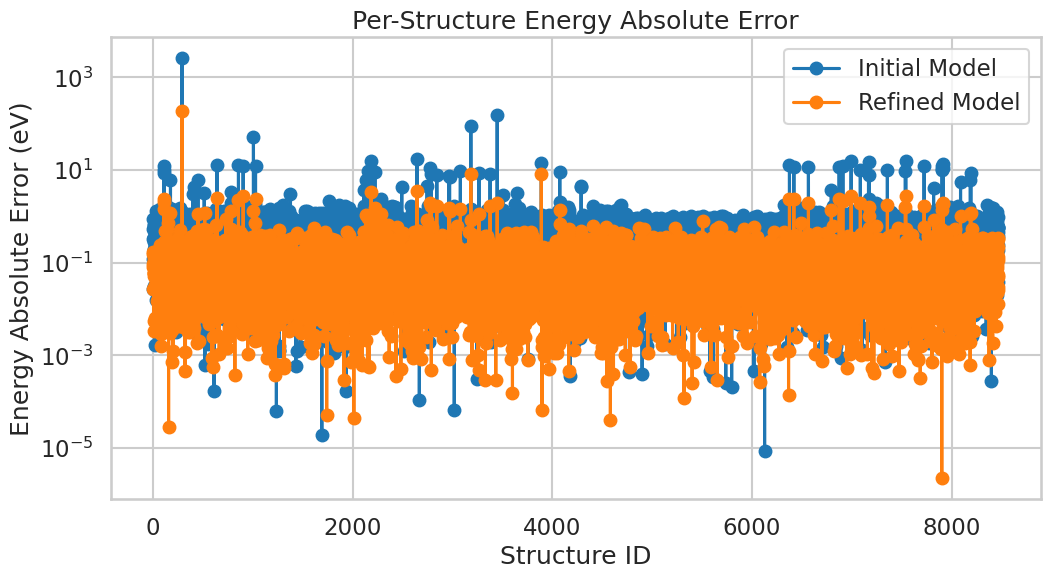

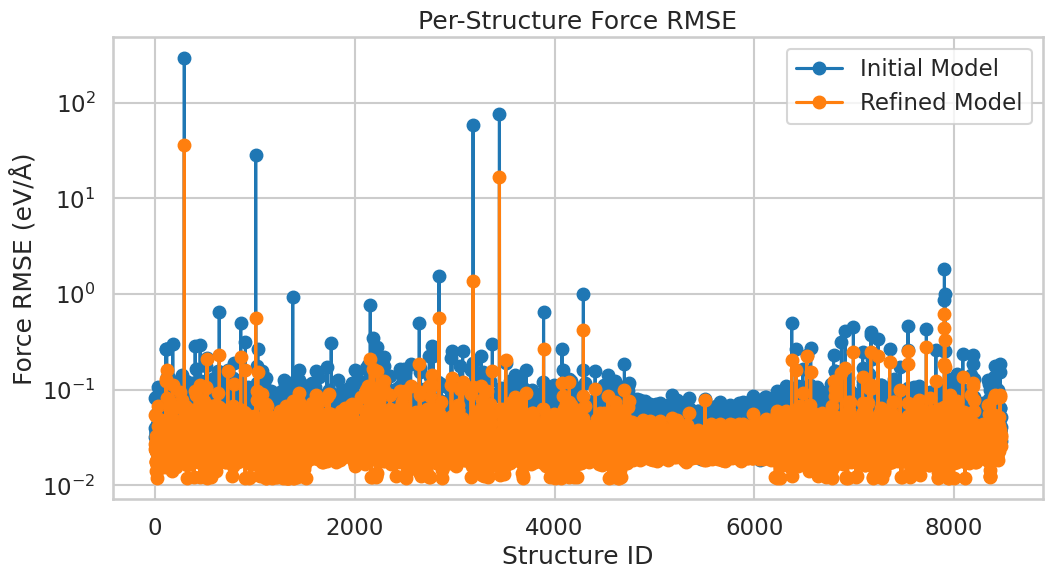

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
import numpy as np
from ase import Atoms

sns.set_context('talk')
sns.set_style('whitegrid')

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

atoms_dict = atoms_dict_copy

# Extract data from atoms_dict
energies = [atoms_dict[i]['energy'] for i in atoms_dict]
in_pred_energies = [atoms_dict[i]['in_pred_energy'] for i in atoms_dict]
ref_pred_energies = [atoms_dict[i]['ref_pred_energy'] for i in atoms_dict]

#forces = np.concatenate([atoms_dict[i]['force'] for i in atoms_dict])
forces = np.concatenate([atoms_dict[i]['force'] for i in atoms_dict]).flatten()
in_pred_forces = np.concatenate([atoms_dict[i]['in_pred_force'] for i in atoms_dict])
ref_pred_forces = np.concatenate([atoms_dict[i]['ref_pred_force'] for i in atoms_dict])

# Calculate overall metrics for energy predictions
r2_in_energy, rmse_in_energy, mae_in_energy = calculate_metrics(energies, in_pred_energies)
r2_ref_energy, rmse_ref_energy, mae_ref_energy = calculate_metrics(energies, ref_pred_energies)

# Calculate overall metrics for force predictions
r2_in_force, rmse_in_force, mae_in_force = calculate_metrics(forces, in_pred_forces)
r2_ref_force, rmse_ref_force, mae_ref_force = calculate_metrics(forces, ref_pred_forces)

# Calculate per-structure errors and add to atoms_dict
for i in atoms_dict:
    # Energy absolute errors
    energy_true = atoms_dict[i]['energy']
    energy_in_pred = atoms_dict[i]['in_pred_energy']
    energy_ref_pred = atoms_dict[i]['ref_pred_energy']
    energy_abs_error_in = abs(energy_true - energy_in_pred)
    energy_abs_error_ref = abs(energy_true - energy_ref_pred)
    atoms_dict[i]['energy_abs_error_in'] = energy_abs_error_in
    atoms_dict[i]['energy_abs_error_ref'] = energy_abs_error_ref

    # Force RMSE per structure
    force_true = atoms_dict[i]['force'].flatten()
    force_in_pred = atoms_dict[i]['in_pred_force'].flatten()
    force_ref_pred = atoms_dict[i]['ref_pred_force'].flatten()
    rmse_in_force = root_mean_squared_error(force_true, force_in_pred)
    rmse_ref_force = root_mean_squared_error(force_true, force_ref_pred)
    atoms_dict[i]['force_rmse_in'] = rmse_in_force
    atoms_dict[i]['force_rmse_ref'] = rmse_ref_force

# Create a list of structures with their errors
structure_errors = []
for i in atoms_dict:
    structure_errors.append({
        'id': i,
        'energy_abs_error_in': atoms_dict[i]['energy_abs_error_in'],
        'energy_abs_error_ref': atoms_dict[i]['energy_abs_error_ref'],
        'force_rmse_in': atoms_dict[i]['force_rmse_in'],
        'force_rmse_ref': atoms_dict[i]['force_rmse_ref'],
    })

# Sort structures by highest force RMSE in the initial model
sorted_structures = sorted(structure_errors, key=lambda x: x['force_rmse_in'], reverse=True)

num_checks = 50
# Print the top 5 structures with highest force RMSE
print(f"Top {num_checks} structures with highest force RMSE in the initial model:")
for idx, item in enumerate(sorted_structures[:num_checks], 1):
    print(f"Structure ID: {item['id']}, Composition : {Atoms.fromdict(atoms_dict[item['id']]['atoms']).get_chemical_formula()}")
    print(f"  Force RMSE (Initial Model): {item['force_rmse_in']:.4f}")
    print(f"  Force RMSE (Refined Model): {item['force_rmse_ref']:.4f}")
    print(f"  Energy Abs Error (Initial Model): {item['energy_abs_error_in']:.4f}")
    print(f"  Energy Abs Error (Refined Model): {item['energy_abs_error_ref']:.4f}\n")

# You can also plot the errors to visualize the outliers
# Plotting energy absolute error per structure
structure_ids = [item['id'] for item in structure_errors]
energy_errors_in = [item['energy_abs_error_in'] for item in structure_errors]
energy_errors_ref = [item['energy_abs_error_ref'] for item in structure_errors]

plt.figure(figsize=(12, 6))
plt.plot(structure_ids, energy_errors_in, label='Initial Model', marker='o')
plt.plot(structure_ids, energy_errors_ref, label='Refined Model', marker='o')
plt.xlabel('Structure ID')
plt.ylabel('Energy Absolute Error (eV)')
plt.yscale('log')
plt.title('Per-Structure Energy Absolute Error')
plt.legend()
plt.show()

# Plotting force RMSE per structure
force_errors_in = [item['force_rmse_in'] for item in structure_errors]
force_errors_ref = [item['force_rmse_ref'] for item in structure_errors]

plt.figure(figsize=(12, 6))
plt.plot(structure_ids, force_errors_in, label='Initial Model', marker='o')
plt.plot(structure_ids, force_errors_ref, label='Refined Model', marker='o')
plt.xlabel('Structure ID')
plt.ylabel('Force RMSE (eV/Å)')
plt.yscale('log')
plt.title('Per-Structure Force RMSE')
plt.legend()
plt.show()

In [17]:
from ase import Atoms
# get the right id 
def compare_predictions(atoms_dict, index):
    atoms = Atoms.fromdict(atoms_dict[index]['atoms'])
    energy = atoms_dict[index]['energy']
    force = atoms_dict[index]['force']
    in_pred_energy = atoms_dict[index]['in_pred_energy']
    in_pred_force = atoms_dict[index]['in_pred_force']
    ref_pred_energy = atoms_dict[index]['ref_pred_energy']
    ref_pred_force = atoms_dict[index]['ref_pred_force']
    print(f"Structure ID: {index}, with compostiion {atoms.get_chemical_formula()}")
    print(f"Actual energy: {energy}")
    print(f"Unreduced energy: {atoms.info['REF_energy']}")
    print(f"Initial model predicted energy: {in_pred_energy}")
    print(f"Refined model predicted energy: {ref_pred_energy}")
    print(f"Energy absolute error (initial model): {abs(energy - in_pred_energy)}")
    print(f"Energy absolute error (refined model): {abs(energy - ref_pred_energy)}")
    #print(f"Actual force: {force}")
    #print(f"Initial model predicted force: {in_pred_force}")
    #print(f"Refined model predicted force: {ref_pred_force}")
    print(f"Force Errors:")
    print(f"Force RMSE (initial model): {root_mean_squared_error(force, in_pred_force)}")
    print(f"Force RMSE (refined model): {root_mean_squared_error(force, ref_pred_force)}")


In [23]:
num_checks = 25
bad_indices = [item['id'] for item in sorted_structures[:num_checks]]
for index in bad_indices:
    compare_predictions(atoms_dict, index)
    print("\n")

Structure ID: 291, with compostiion Cr9Ti9V49W27Zr30
Actual energy: 4393.9829960412
Unreduced energy: 3197.19389022
Initial model predicted energy: 1794.9510498046875
Refined model predicted energy: 4211.388671875
Energy absolute error (initial model): 2599.0319462365123
Energy absolute error (refined model): 182.59432416619984
Force Errors:
Force RMSE (initial model): 293.12165195142524
Force RMSE (refined model): 35.893178123661706


Structure ID: 3448, with compostiion Cr10Ti14V87W2Zr11
Actual energy: 279.44236602219996
Unreduced energy: -821.40083178
Initial model predicted energy: 129.59490966796875
Refined model predicted energy: 277.5237731933594
Energy absolute error (initial model): 149.8474563542312
Energy absolute error (refined model): 1.9185928288405876
Force Errors:
Force RMSE (initial model): 76.10606683049895
Force RMSE (refined model): 16.778580564845374


Structure ID: 3184, with compostiion Cr10Ti14V87W2Zr11
Actual energy: 136.6467714421999
Unreduced energy: -964.196

In [19]:
# Save the sorted structures to an xyz file
from ase.io import write

num_checks = 10
# Create a list of Atoms objects for the top structures
top_structures = [Atoms.fromdict(atoms_dict[item['id']]['atoms']) for item in sorted_structures[:num_checks]]

# Write the top structures to an xyz file
write('top_10_bad_structures.xyz', top_structures)

In [110]:
print(len(sorted_structures))
write('problem_atom.xyz',[Atoms.fromdict(atoms_dict[sorted_structures[i]['id']]['atoms']) for i in range(5)])

3448


Initial Model - Min: 18.18301381351275, Max: 293121.65195142524
Refined Model - Min: 11.906779685706931, Max: 35893.1781236617


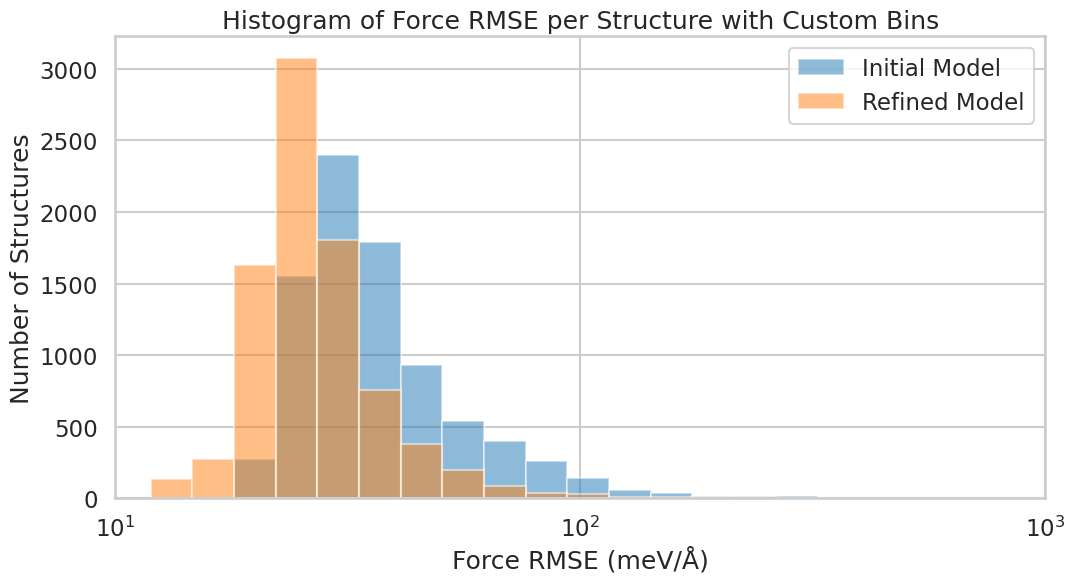

In [20]:
import matplotlib.pyplot as plt

# Extract and scale the error values to meV
in_forces = [sorted_structures[i]['force_rmse_in'] for i in range(len(sorted_structures))]
ref_forces = [sorted_structures[i]['force_rmse_ref'] for i in range(len(sorted_structures))]
in_forces_scaled = [error * 1000 for error in in_forces]
ref_forces_scaled = [error * 1000 for error in ref_forces]

# Check the range of the data
print(f"Initial Model - Min: {min(in_forces_scaled)}, Max: {max(in_forces_scaled)}")
print(f"Refined Model - Min: {min(ref_forces_scaled)}, Max: {max(ref_forces_scaled)}")

# Adjust the bin edges manually if needed
bin_edges = np.logspace(np.log10(min(in_forces_scaled + ref_forces_scaled)), np.log10(max(in_forces_scaled + ref_forces_scaled)), 50)

plt.figure(figsize=(12, 6))

# Plot histograms with custom bin edges
plt.hist(in_forces_scaled, bins=bin_edges, alpha=0.5, label='Initial Model')
plt.hist(ref_forces_scaled, bins=bin_edges, alpha=0.5, label='Refined Model')

# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlim(1E1, 1E3)

plt.xlabel('Force RMSE (meV/Å)')
plt.ylabel('Number of Structures')
plt.title('Histogram of Force RMSE per Structure with Custom Bins')
plt.legend()

plt.show()

## Save the fixed dataset and retrain!

In [21]:
# get the ids of the structures with the highest force RMSE in the initial model 
num_checks = 5
bad_indices = [item['id'] for item in sorted_structures[:num_checks]]

for index in bad_indices:
    compare_predictions(atoms_dict, index)
    print("\n")

Structure ID: 291, with compostiion Cr9Ti9V49W27Zr30
Actual energy: 4393.9829960412
Unreduced energy: 3197.19389022
Initial model predicted energy: 1794.9510498046875
Refined model predicted energy: 4211.388671875
Energy absolute error (initial model): 2599.0319462365123
Energy absolute error (refined model): 182.59432416619984
Force Errors:
Force RMSE (initial model): 293.12165195142524
Force RMSE (refined model): 35.893178123661706


Structure ID: 3448, with compostiion Cr10Ti14V87W2Zr11
Actual energy: 279.44236602219996
Unreduced energy: -821.40083178
Initial model predicted energy: 129.59490966796875
Refined model predicted energy: 277.5237731933594
Energy absolute error (initial model): 149.8474563542312
Energy absolute error (refined model): 1.9185928288405876
Force Errors:
Force RMSE (initial model): 76.10606683049895
Force RMSE (refined model): 16.778580564845374


Structure ID: 3184, with compostiion Cr10Ti14V87W2Zr11
Actual energy: 136.6467714421999
Unreduced energy: -964.196

In [22]:
import copy
import hashlib
from ase.io import write
from ase import Atoms

def hash_atoms(atoms):
    """
    Create a unique hash for an atoms object based on its positions and numbers.
    """
    positions = atoms.positions.tobytes()
    numbers = atoms.numbers.tobytes()
    return hashlib.sha256(positions + numbers).hexdigest()

def remove_atoms_with_hash(larger_set, atoms_to_remove):
    """
    Remove atoms objects from larger_set that exist in atoms_to_remove.
    Return a list of remaining atoms objects.
    """
    atoms_to_remove_hashes = {hash_atoms(atoms) for atoms in atoms_to_remove}
    remaining_atoms = [atoms for atoms in larger_set if hash_atoms(atoms) not in atoms_to_remove_hashes]
    return remaining_atoms

# Example usage
# Assuming atoms_dict and bad_indices are already defined
bad_atoms = [Atoms.fromdict(atoms_dict[idx]['atoms']) for idx in bad_indices]
print(f"The bad atoms are {bad_indices}")

# Make a deep copy of nov_05_unique_copy_copy
nov_05_copy = copy.deepcopy(nov_05)

# Remove bad atoms from the larger set
remaining_atoms = remove_atoms_with_hash(nov_05_copy, bad_atoms)

print(f"Number of atoms in nov_05_unique_copy: {len(nov_05_unique_copy)}")
print(f"Number of atoms in nov_05_unique_copy_copy: {len(remaining_atoms)}")
# Save the remaining atoms as an .xyz file
write('2024-11-06_all_remaining_atoms.xyz', remaining_atoms)

The bad atoms are [291, 3448, 3184, 1006, 7906]
Number of atoms in nov_05_unique_copy: 8471
Number of atoms in nov_05_unique_copy_copy: 8471
